In [28]:
# all required imports
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from geopy.distance import geodesic
import json
import os
import sys
import math
import random
import datetime
import scipy as sp
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [29]:
#reading the training data and test data
json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']

train_data = pd.read_csv("./../input/train.csv", low_memory=False, error_bad_lines=False, header=0,
                         dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, 
                         converters={column: json.loads for column in json_cols}, nrows=None)
                         #skiprows=lambda i: i>0 and random.random() > 0.02)

# Reference: https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook
# adding subcolumns from json columns in training data
for col_name in json_cols:
    column_as_df = json_normalize(train_data[col_name])
    column_as_df.columns = [f"{col_name}.{subcolumn}" for subcolumn in column_as_df.columns]
    train_data = train_data.drop(col_name, axis=1).merge(column_as_df, right_index=True, left_index=True)


test_data = pd.read_csv("./../input/test.csv", low_memory=False, error_bad_lines=False, header=0,
                         dtype={'date': str, 'fullVisitorId': str, 'sessionId':str}, 
                         converters={column: json.loads for column in json_cols}, nrows=None)

for col_name in json_cols:
    column_as_df = json_normalize(test_data[col_name])
    column_as_df.columns = [f"{col_name}.{subcolumn}" for subcolumn in column_as_df.columns]
    test_data = test_data.drop(col_name, axis=1).merge(column_as_df, right_index=True, left_index=True)

print(train_data.keys())

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

In [30]:
# changing dtype of columns from string to int
cols = ['totals.transactionRevenue', 'totals.hits', 'totals.pageviews']

for col in cols:
    train_data[col] = pd.to_numeric(train_data[col])
    if col != 'totals.transactionRevenue':
        test_data[col] = pd.to_numeric(test_data[col])
    

In [31]:
# handling NaN values in relevant columns

def replace_nan_with_zero(cols):
    for col in cols:
        train_data[col].fillna(0,inplace=True)
        if col != 'totals.transactionRevenue':
            test_data[col].fillna(0,inplace=True)
    
cols = ['trafficSource.adwordsClickInfo.page', 'trafficSource.isTrueDirect', 'totals.newVisits', 'totals.bounces'
        , 'totals.transactionRevenue', 'trafficSource.adwordsClickInfo.isVideoAd', 'totals.pageviews']
replace_nan_with_zero(cols)

#train_data.dropna(how = 'any', axis = 'rows')

In [32]:
# deleting columns with too many NaN values
cols = train_data.keys()

# percentage of nan values
for col in cols:
    nan_cnt = sum(pd.isnull(train_data[col]))
    percent = 100*nan_cnt/len(train_data[col])
    if percent > 80:
        print("%s has %s%% NaN, Deleting..." % (col, percent))
        del train_data[col]
        if col in test_data:
            del test_data[col]

#col_with_nan = ['trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 
#                'trafficSource.adwordsClickInfo.gclId','trafficSource.keyword', 'trafficSource.referralPath',
#                'trafficSource.adwordsClickInfo.slot']

trafficSource.adContent has 98.78869433289105% NaN, Deleting...
trafficSource.adwordsClickInfo.adNetworkType has 97.62519462669852% NaN, Deleting...
trafficSource.adwordsClickInfo.gclId has 97.61401777009537% NaN, Deleting...
trafficSource.adwordsClickInfo.slot has 97.62519462669852% NaN, Deleting...
trafficSource.campaignCode has 99.99988933805344% NaN, Deleting...


In [33]:
# deleting columns with just one unique

#col_with_one_unique_val = ['socialEngagementType', 'totals.visits'] # checked: ['campaign', 'source', 'medium']

cols = train_data.keys()
for col_name in cols:
    #print(train_data[col_name].unique())
    if len(train_data[col_name].unique()) == 1:
        print(train_data[col_name].unique())
        print("Deleted: '%s'" % (col_name))
        del train_data[col_name]
        del test_data[col_name]

['Not Socially Engaged']
Deleted: 'socialEngagementType'
['not available in demo dataset']
Deleted: 'device.browserSize'
['not available in demo dataset']
Deleted: 'device.browserVersion'
['not available in demo dataset']
Deleted: 'device.flashVersion'
['not available in demo dataset']
Deleted: 'device.language'
['not available in demo dataset']
Deleted: 'device.mobileDeviceBranding'
['not available in demo dataset']
Deleted: 'device.mobileDeviceInfo'
['not available in demo dataset']
Deleted: 'device.mobileDeviceMarketingName'
['not available in demo dataset']
Deleted: 'device.mobileDeviceModel'
['not available in demo dataset']
Deleted: 'device.mobileInputSelector'
['not available in demo dataset']
Deleted: 'device.operatingSystemVersion'
['not available in demo dataset']
Deleted: 'device.screenColors'
['not available in demo dataset']
Deleted: 'device.screenResolution'
['not available in demo dataset']
Deleted: 'geoNetwork.cityId'
['not available in demo dataset']
Deleted: 'geoNetwo

In [34]:
# deleting columns whose more than 60% values are censored

cols = train_data.keys()
# percentage of nan values
for col in cols:
    if train_data[col].dtype == 'O':
        nan_cnt = (train_data[col] == 'not available in demo dataset').sum()
        nan_cnt += (train_data[col] == '(not set)').sum()
        
        percent = 100*nan_cnt/len(train_data[col])
        if percent > 50:
            print("%s has %s%% censored data, Deleting..." % (col, percent))
            del train_data[col]
            del test_data[col]

geoNetwork.city has 60.03311005441248% censored data, Deleting...
geoNetwork.metro has 78.56942875196563% censored data, Deleting...
geoNetwork.region has 59.32100042826173% censored data, Deleting...
trafficSource.campaign has 95.76098347485151% censored data, Deleting...


In [35]:
# deleting columns which are not relevant for revenue prediction
col_to_del = ['geoNetwork.networkDomain', 'sessionId']

for col_name in col_to_del:
    del train_data[col_name]
    del test_data[col_name]

In [36]:
# backup for re-running from here
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

In [37]:
# adding year, month, day and day_of_week
for df in [train_data, test_data]:
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_month'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['hour'] = df['date'].dt.hour

del train_data['date']
del test_data['date']

In [38]:
not_to_convert = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'day_of_month', 'day_of_week', 'hour'
]


# map categorical data to integers

for col in train_data.keys():
    if (col not in not_to_convert) & (train_data[col].dtype == 'object'):
        train_data[col], indexer = pd.factorize(train_data[col])
        test_data[col] = indexer.get_indexer(test_data[col])

In [39]:
# removing rows which still have Nan values
print(len(train_data))
#train_data.dropna(how = 'any', axis = 'rows', inplace=True)
#test_data.dropna(how = 'any', axis = 'rows', inplace=True)
len(train_data)

903653


903653

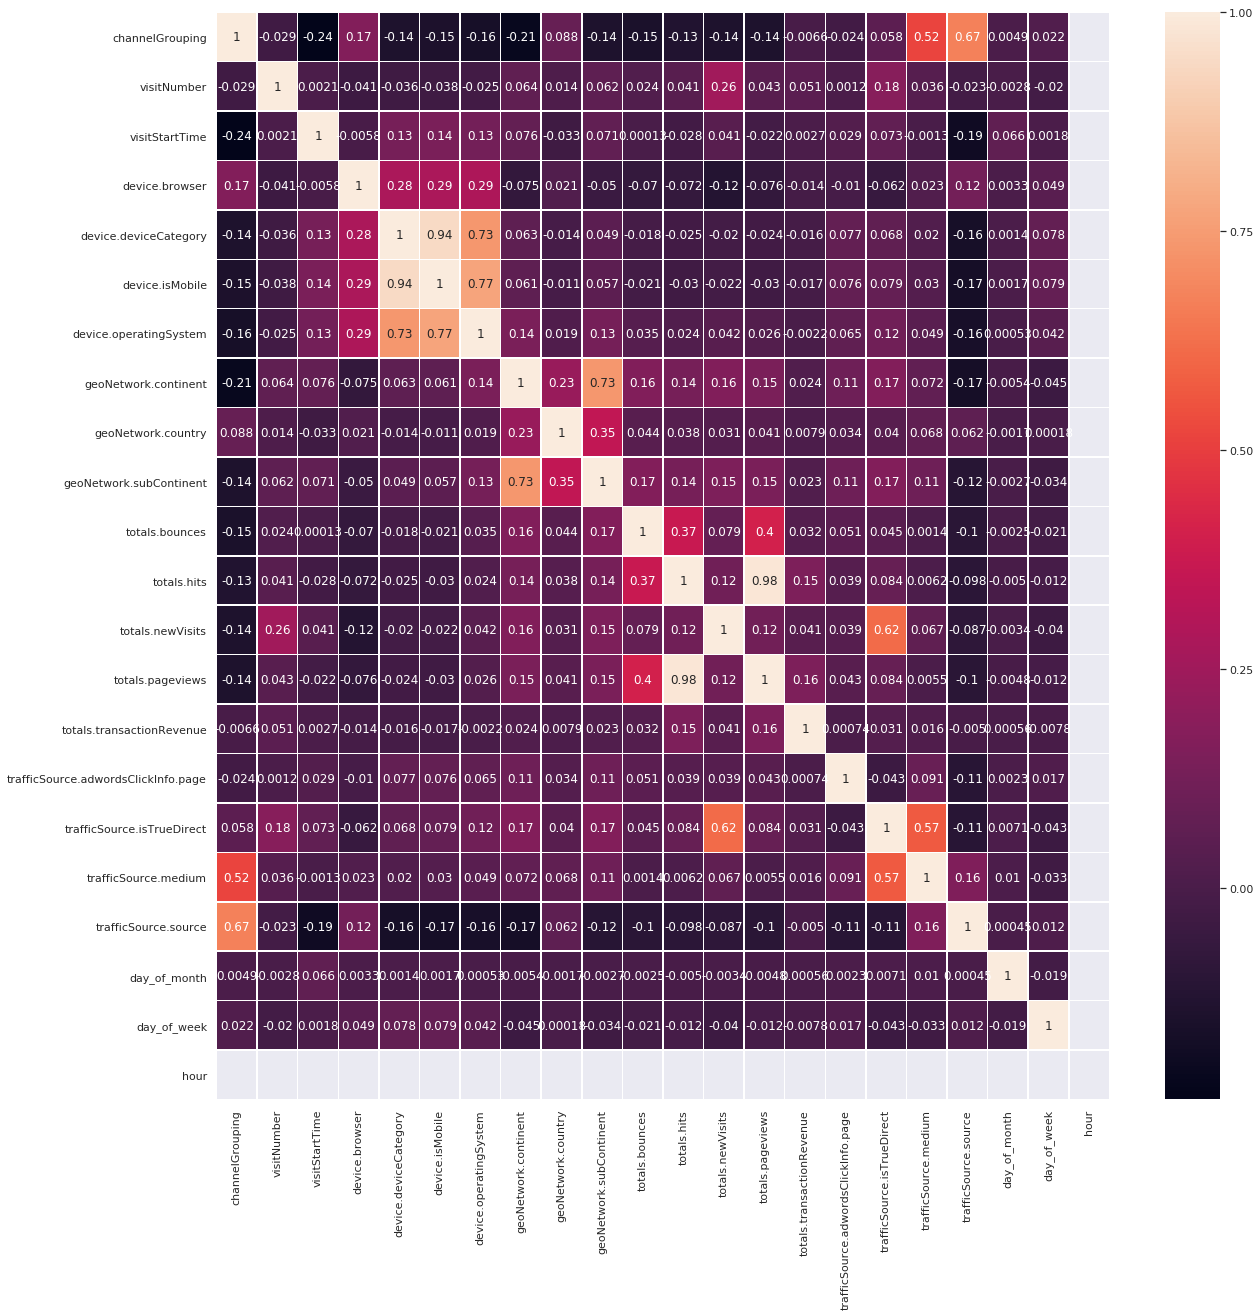

In [40]:
# Q2. Plot 1

#print(train_data.isnull().sum())
correlation_cols = ['channelGrouping', 'visitNumber', 'visitStartTime', 'device.browser',
                   'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
                   'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.subContinent',
                   'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews',
                   'totals.transactionRevenue', 'trafficSource.adwordsClickInfo.page',
                   'trafficSource.isTrueDirect', 'trafficSource.medium',
                   'trafficSource.source', 'day_of_month', 'day_of_week', 'hour']#,
#                   'trafficSource.keyword', 'trafficSource.referralPath']

sns.set()
correlation_data = train_data[correlation_cols]

correlation = correlation_data.corr()
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(correlation, annot=True, linewidths=.5, ax=ax)
plt.show()

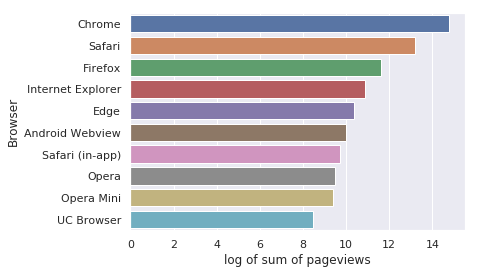

In [50]:
#Q2. Plot 2

# plot of log of totals.pageviews for each browser
total_hits_on_browser = train_data_copy.groupby('device.browser',as_index=False).agg({"totals.pageviews": "sum"})
total_hits_on_browser = total_hits_on_browser.sort_values(by=['totals.pageviews'],ascending=False)
total_hits_on_browser['totals.pageviews'] = np.log1p(total_hits_on_browser['totals.pageviews'])

g = sns.barplot('totals.pageviews', "device.browser", data=total_hits_on_browser.head(10))
g.set(xlabel='log of sum of pageviews', ylabel='Browser')
plt.show()

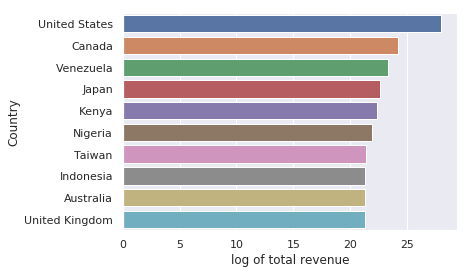

In [42]:
# Q2. Plot 3

transactions = train_data_copy.groupby('geoNetwork.country',as_index=False).agg({"totals.transactionRevenue": "sum"})    
transactions['totals.transactionRevenue'] = np.log1p(transactions['totals.transactionRevenue'])
transactions = transactions.sort_values(by=['totals.transactionRevenue'],ascending=False)
g = sns.barplot("totals.transactionRevenue", 'geoNetwork.country', data=transactions.head(10))
g.set(xlabel='log of total revenue', ylabel="Country")
plt.show()


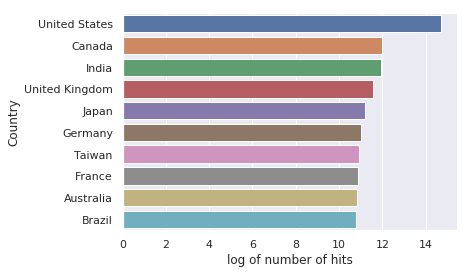

In [43]:
# Geographic clustering
customers = train_data_copy.groupby('geoNetwork.country',as_index=False).agg({"totals.hits": "sum"})    
customers['totals.hits'] = np.log(customers['totals.hits'])
customers = customers.sort_values(by=['totals.hits'],ascending=False)
g = sns.barplot("totals.hits", 'geoNetwork.country', data=customers.head(10))
g.set(xlabel='log of number of hits', ylabel='Country')
plt.show()

In [44]:
# As we saw in the correlation matrix that, totals.revenue is having a better correlation with totals.hits,
# totals.pageviews
# So, let's create a approximate formula for Buying Score, B = (hits)^2 + view // hits is more important as it shows 
# user's interest in the page

aggObj = {'totals.hits': 'sum',
          'totals.pageviews': 'sum',
          'visitNumber': 'sum'
         }

top_customers_by_score = train_data_copy.groupby('fullVisitorId', as_index=False).agg(aggObj)
#top_customers_by_score['buying_score'] = top_customers_by_score['totals.hits'] ** 2 + top_customers_by_score['totals.pageviews'] 

top_customers_by_score['buying_score'] =  top_customers_by_score['totals.hits'] / (top_customers_by_score['totals.pageviews']+1)
top_customers_by_score = top_customers_by_score.sort_values(by=['buying_score'],ascending=False)

print("According to Buying Score Function, ten most likely users who will buy a product from the store are:")
print(top_customers_by_score['fullVisitorId'][:10])

top_customers_by_revenue = train_data_copy.groupby('fullVisitorId', as_index=False).agg({'totals.transactionRevenue': 'sum'})
top_customers_by_revenue = top_customers_by_revenue.sort_values(by=['totals.transactionRevenue'],ascending=False)

print("According to given total revenue, ten most likely users who will buy a product from the store are:")
print(top_customers_by_revenue['fullVisitorId'][:10])

According to Buying Score Function, ten most likely users who will buy a product from the store are:
649511    9093363280493368870
146896    2059972253358377682
528116    7397493441124440250
619934    8681139511581582871
501054      70196377514277213
45881      064497836207824698
465003     651583646291677350
704962    9870829041844892998
478390    6703923894403051630
696528    9751687059892672069
Name: fullVisitorId, dtype: object
According to given total revenue, ten most likely users who will buy a product from the store are:
139589    1957458976293878100
401727    5632276788326171571
672547    9417857471295131045
318933    4471415710206918415
355406    4984366501121503466
649241    9089132392240687728
644997    9029794295932939024
532813    7463172420271311409
521958    7311242886083854158
565543      79204932396995037
Name: fullVisitorId, dtype: object


In [45]:
'''i = 0
for key in train_data.keys():
    print("%s : % s ----- unique=%s" % (key, train_data.values[0][i], len(train_data[key].unique())))
    i += 1
print(i)
'''

'i = 0\nfor key in train_data.keys():\n    print("%s : % s ----- unique=%s" % (key, train_data.values[0][i], len(train_data[key].unique())))\n    i += 1\nprint(i)\n'

In [46]:
# Linear Regression

not_to_use =  {'fullVisitorId', 'visitId', 'visitStartTime', 'sessionId'}
to_use = [col for col in train_data.columns if col not in not_to_use]

train_data = train_data[to_use]
print(train_data.keys())

train_y = np.log1p(train_data['totals.transactionRevenue'].values)
del train_data['totals.transactionRevenue']
train_x = train_data.copy()
test_data_for_pred = test_data[train_x.keys()]


lr_train_x, lr_test_x , lr_train_y, lr_test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=23)

#train_x = get_training_features(train_data)
#test_x = get_training_features(test_data)


# Linear Regression model initialization
linear_regression_adv = LinearRegression()

# Training the Linear Regression Model
linear_regression_adv.fit(lr_train_x, lr_train_y)
print(linear_regression_adv.coef_)

# Predict fare_amount for training data to get calculate errors
pre_test_y = linear_regression_adv.predict(lr_test_x)

# Mean squared error and variance
print("Mean squared error: %.5f" % mean_squared_error(lr_test_y, pre_test_y))
print('Variance : %.5f' % r2_score(lr_test_y, pre_test_y)) #

# Predict revenue
test_y = linear_regression_adv.predict(test_data_for_pred)

# saving predicted output to file
pred_data = pd.DataFrame({"fullVisitorId":test_data["fullVisitorId"].values})
test_y[test_y<0] = 0
pred_data["PredictedLogRevenue"] = np.expm1(test_y)
pred_data = pred_data.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
pred_data.columns = ["fullVisitorId", "PredictedLogRevenue"]
pred_data["PredictedLogRevenue"] = np.log1p(pred_data["PredictedLogRevenue"])
pred_data.to_csv("baseline_linearReg.csv", index=False)

Index(['channelGrouping', 'visitNumber', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.subContinent',
       'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue', 'trafficSource.adwordsClickInfo.page',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source', 'day_of_month', 'day_of_week', 'hour'],
      dtype='object')
[ 1.09424530e-02 -2.69357020e-03 -1.98158293e-03 -4.16991680e-02
 -1.91012759e-01  3.39005200e-02  3.12403675e-02  4.72206036e-05
  4.91700322e-03 -3.38696901e-01 -1.17464377e-01  2.70557461e-01
  2.81764171e-01 -6.93635963e-02  5.70079086e-02  5.21812815e-05
 -1.22163385e-02 -2.59334014e-04  2.38038232e-03  5.30101526e-04
 -5.27099307e-03  0.00000000e+00]
Mean squared error: 3.32822
Variance : 0.16128


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.67343
[200]	valid_0's rmse: 1.65693
[300]	valid_0's rmse: 1.64932
[400]	valid_0's rmse: 1.64871
Early stopping, best iteration is:
[361]	valid_0's rmse: 1.64846
Mean squared error: 2.71743
Variance : 0.31520


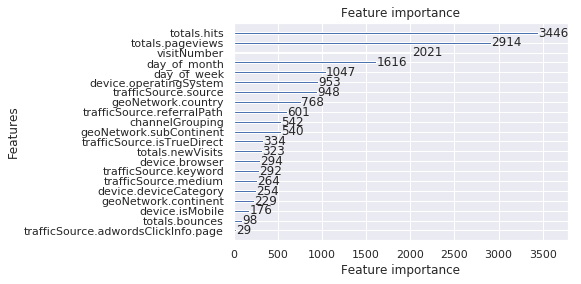

In [47]:
# light gbm model
def run_lgb(train_x, train_y, val_x, val_y, test_x, iterations=4000):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 50,
        "min_child_samples" : 100,
        "learning_rate" : 0.03,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2019,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_x, label=train_y)
    lgval = lgb.Dataset(val_x, label=val_y)
    model = lgb.train(params, lgtrain, iterations, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    test_y = model.predict(test_x, num_iteration=model.best_iteration)
    pred_test_y = model.predict(val_x, num_iteration=model.best_iteration)
    return pred_test_y, model, test_y

pre_test_y, model, test_y = run_lgb(lr_train_x, lr_train_y, lr_test_x, lr_test_y, test_data_for_pred)

# Mean squared error and variance
print("Mean squared error: %.5f" % mean_squared_error(lr_test_y, pre_test_y))
print('Variance : %.5f' % r2_score(lr_test_y, pre_test_y))

# write prediction to csv file
pred_data = pd.DataFrame({"fullVisitorId":test_data["fullVisitorId"].values})
test_y[test_y<0] = 0
pred_data["PredictedLogRevenue"] = np.expm1(test_y)
pred_data = pred_data.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
pred_data.columns = ["fullVisitorId", "PredictedLogRevenue"]
pred_data["PredictedLogRevenue"] = np.log1p(pred_data["PredictedLogRevenue"])
pred_data.to_csv("baseline_lgb.csv", index=False)

lgb.plot_importance(model, max_num_features=30)

In [48]:
#train_data = train_data_copy.copy()
#test_data = test_data_copy.copy()

In [49]:
# Q7. 
from random import *

cols_to_permute = lr_train_x.keys()

permutation_data = []
for col in cols_to_permute:
    print("permuting over %s" % col)
    # making a deep copy of train_x
    new_train_x = train_x.copy()#[cols_to_permute]
    
    # shuffling col
    #print("started shuffling %s" % col)
    shuffled = new_train_x[col].sample(frac=1).reset_index(drop=True)
    new_train_x[col] = shuffled
    #print("shuffled %s" % col)
    
    lr_train_x, lr_test_x , lr_train_y, lr_test_y = train_test_split(new_train_x, train_y, test_size=0.2, random_state=23)
    
    pre_test_y, model, test_y = run_lgb(lr_train_x, lr_train_y, lr_test_x, lr_test_y, test_data_for_pred, 50)
    
    permutation_data.append({
        'permuted': col,
        'rmse': mean_squared_error(lr_test_y, pre_test_y)
    });

print("\n\n\n Permutation data: ")
for data in permutation_data:
    print(data)

permuting over channelGrouping
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 1.70958
permuting over visitNumber
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 1.71107
permuting over device.browser
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 1.7094
permuting over device.deviceCategory
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 1.71001
permuting over device.isMobile
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 1.70961
permuting over device.operatingSystem
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration 